In [1]:
import mne
import os
import os.path as op
import numpy as np
import pickle
from warnings import filterwarnings
from sys import argv
import matplotlib.pyplot as plt
from stormdb.access import Query
import pandas as pd
from src.preprocessing import WM_epoching, main_task_events_fun, default_events_fun
filterwarnings("ignore", category=DeprecationWarning)

In [45]:
project = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
project_dir = '/projects/' + project
os.environ['MINDLABPROJ']= project
#os.environ['MNE_ROOT']='/users/david/miniconda3/envs/mne3d' # for surfer
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.2'

raw_path = project_dir + '/scratch/maxfiltered_data/tsss_st16_corr96'
ica_path = project_dir + '/scratch/working_memory/ICA'
avg_path = project_dir + '/scratch/working_memory/averages'
log_path = project_dir + '/misc/working_memory_logs'

subjects_dir = project_dir + '/scratch/fs_subjects_dir'
fwd_path = project_dir + '/scratch/forward_models'

qy = Query(project)
subs = qy.get_subjects()
scode = 21
# if len(argv) > 1:
#     scode = int(argv[1])

sub = subs[scode-1] #'0002_BYG'#'0002_BYG'#'0008_HMD'#'0002_BYG'
conds_orig = ['main','inv'] #  ['mainv2','invv2']
conds = ['maintenance','manipulation']
lnames = ['recognize','invert']
save_averages = True#False#True
plot_topo = True#True
compute_sources = True # False
plot_sources = False
# sub, conds, save_averages,  = argv[0], argv[1], argv[2]
# plot_topo, compute_sources, plot_sources = argv[3], argv[4]


In [46]:
## Alternative epoching strategy
tmin = -1
tmax = 4
reject = dict(mag = 4e-12, grad = 4000e-13)
epochs = {}
evokeds = {}
print('\n epoching \n')
for cidx, c in enumerate(conds_orig):
    nc = conds[cidx]
    fname = os.path.join(raw_path, sub, c + '_raw_tsss.fif')
    icaname = os.path.join(ica_path,sub, c + '_raw_tsss-ica.fif')
    lfname = op.join(log_path, sub[0:4] + '_' + lnames[cidx] + '_MEG.csv')
    epochs[nc] = WM_epoching(data_path=fname, ica_path=icaname, tmin=tmin, tmax=tmax,
                                    l_freq=None, h_freq=None, resample = 400, bads=[],
                                baseline=None, notch_filter=50,
                                events_fun=main_task_events_fun, events_fun_kwargs = {'cond': nc, 'lfname': lfname},
                                reject=reject)


 epoching 

Opening raw data file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/maxfiltered_data/tsss_st16_corr96/0021_LZW/main_raw_tsss.fif...
    Range : 7000 ... 602999 =      7.000 ...   602.999 secs
Ready.
Reading 0 ... 595999  =      0.000 ...   595.999 secs...
Reading /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/ICA/0021_LZW/main_raw_tsss-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 306 PCA components
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.6

In [47]:
epochs = mne.concatenate_epochs([epochs[e] for e in epochs])

Not setting metadata
Not setting metadata
118 matching events found
No baseline correction applied
0 bad epochs dropped


In [48]:
def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, picks='all',n_jobs=2):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,average=False,n_jobs = n_jobs,picks=picks)
    
    print('log transforming')
    for r in np.arange(TFR.data.shape[0]):
        print('trial ', r+1)
        TFR.data[r] = np.log(TFR.data[r])
        
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(0,3),keepdims=True)
        TFR.data -= bmean 
        TFR.data /= bstd
    return TFR

In [49]:
def plot_induced_TFR(TFR, ncols = 4, elec=None, savefig=None, show=False, vlines = [0,2,4], hlines = []):
    chans =TFR.info['ch_names'] # Get channels
    nrows = int(np.ceil(len(chans)/ncols)) # Calculate number of rows
    
    #Begin plotting
    print('plotting...')
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (20,nrows*4))
    for chix, ch in enumerate(chans):
        
        # Check if there is electrode info to add anatomical information to titles
        if isinstance(elec, pd.DataFrame):
            elecix = np.where(elec['electrode'] == ch)
            title = ch + ' ' + list(elec.loc[elecix]['name'])[0]
        else:
            title = ch
        print(title)
                
        # Plot according to axis
        if nrows == 1:
            cax=ax[chix]
        else:
            cax=ax[chix//ncols,chix%ncols]

        cdata = np.squeeze(TFR.data[chix])
        im = cax.matshow(cdata, vmin=-1,vmax=1,cmap='RdBu_r',aspect = 'auto',origin='lower',
                         interpolation = 'nearest', extent=[TFR.times[0],TFR.times[-1],0,len(TFR.freqs)])
        
        for v in vlines:
            cax.axvline(v,color='k',alpha=.6)
        
        for h in hlines:
            cax.axhline(h,color='k',alpha=.6)
            
        plt.colorbar(im, ax=cax)
        cax.set_yticks(np.arange(0, len(TFR.freqs))+.5)
        cax.set_yticklabels(TFR.freqs)
        cax.set_ylabel('frequency (Hz)')
        cax.set_xlabel('time (s)')
        cax.set_title(title)
        cax.xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    
    # Save
    if savefig:
        print('saving figure to ' + savefig)
        plt.savefig(savefig)
        
    # Show if required
    if show:
        plt.show()

In [70]:
# freqs = np.array([1,2,3,4,5,6,7,8,10,12,15,18,21,24,27,30,36,42,48,54,60,70,80,90,100,110,120,130,140,150])
# bwidth = np.array([1,1,1,1,1,1,1,2,2,2,3,3,3,3,3,3,6,6,6,6,6,10,10,10,10,10,10,10,10,10])

freqs = np.array([70,80,90,100,110,120,130,140,150])
bwidth = np.array([10,10,10,10,10,10,10,10,10])

#freqs = np.array([36,42,48,54,60])
#bwidth = np.array([6,6,6,6,6])

# freqs = np.array([1,2,3,4,5,6,7,8])
# bwidth = np.array([1,1,1,1,1,1,1,1])

time_bandwidth = 2
n_cycles = freqs * time_bandwidth / bwidth
print('decomposing epochs')

TFRhigh = MM_compute_TFR(epochs,freqs,n_cycles,baseline = [-1,0], zscore=True, n_jobs=4, picks = 'mag')

decomposing epochs
computing TFR


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 102 out of 102 | elapsed:    9.5s finished


Not setting metadata
log transforming
trial  1
trial  2
trial  3
trial  4
trial  5
trial  6
trial  7
trial  8
trial  9
trial  10
trial  11
trial  12
trial  13
trial  14
trial  15
trial  16
trial  17
trial  18
trial  19
trial  20
trial  21
trial  22
trial  23
trial  24
trial  25
trial  26
trial  27
trial  28
trial  29
trial  30
trial  31
trial  32
trial  33
trial  34
trial  35
trial  36
trial  37
trial  38
trial  39
trial  40
trial  41
trial  42
trial  43
trial  44
trial  45
trial  46
trial  47
trial  48
trial  49
trial  50
trial  51
trial  52
trial  53
trial  54
trial  55
trial  56
trial  57
trial  58
trial  59
trial  60
trial  61
trial  62
trial  63
trial  64
trial  65
trial  66
trial  67
trial  68
trial  69
trial  70
trial  71
trial  72
trial  73
trial  74
trial  75
trial  76
trial  77
trial  78
trial  79
trial  80
trial  81
trial  82
trial  83
trial  84
trial  85
trial  86
trial  87
trial  88
trial  89
trial  90
trial  91
trial  92
trial  93
trial  94
trial  95
trial  96
trial  97
t

Applying baseline correction (mode: mean)
plotting...
MEG0111
MEG0121
MEG0131
MEG0141
MEG0211
MEG0221
MEG0231
MEG0241
MEG0311
MEG0321
MEG0331
MEG0341
MEG0411
MEG0421
MEG0431
MEG0441
MEG0511
MEG0521
MEG0531
MEG0541
MEG0611
MEG0621
MEG0631
MEG0641
MEG0711
MEG0721
MEG0731
MEG0741
MEG0811
MEG0821
MEG0911
MEG0921
MEG0931
MEG0941
MEG1011
MEG1021
MEG1031
MEG1041
MEG1111
MEG1121
MEG1131
MEG1141
MEG1211
MEG1221
MEG1231
MEG1241
MEG1311
MEG1321
MEG1331
MEG1341
MEG1411
MEG1421
MEG1431
MEG1441
MEG1511
MEG1521
MEG1531
MEG1541
MEG1611
MEG1621
MEG1631
MEG1641
MEG1711
MEG1721
MEG1731
MEG1741
MEG1811
MEG1821
MEG1831
MEG1841
MEG1911
MEG1921
MEG1931
MEG1941
MEG2011
MEG2021
MEG2031
MEG2041
MEG2111
MEG2121
MEG2131
MEG2141
MEG2211
MEG2221
MEG2231
MEG2241
MEG2311
MEG2321
MEG2331
MEG2341
MEG2411
MEG2421
MEG2431
MEG2441
MEG2511
MEG2521
MEG2531
MEG2541
MEG2611
MEG2621
MEG2631
MEG2641


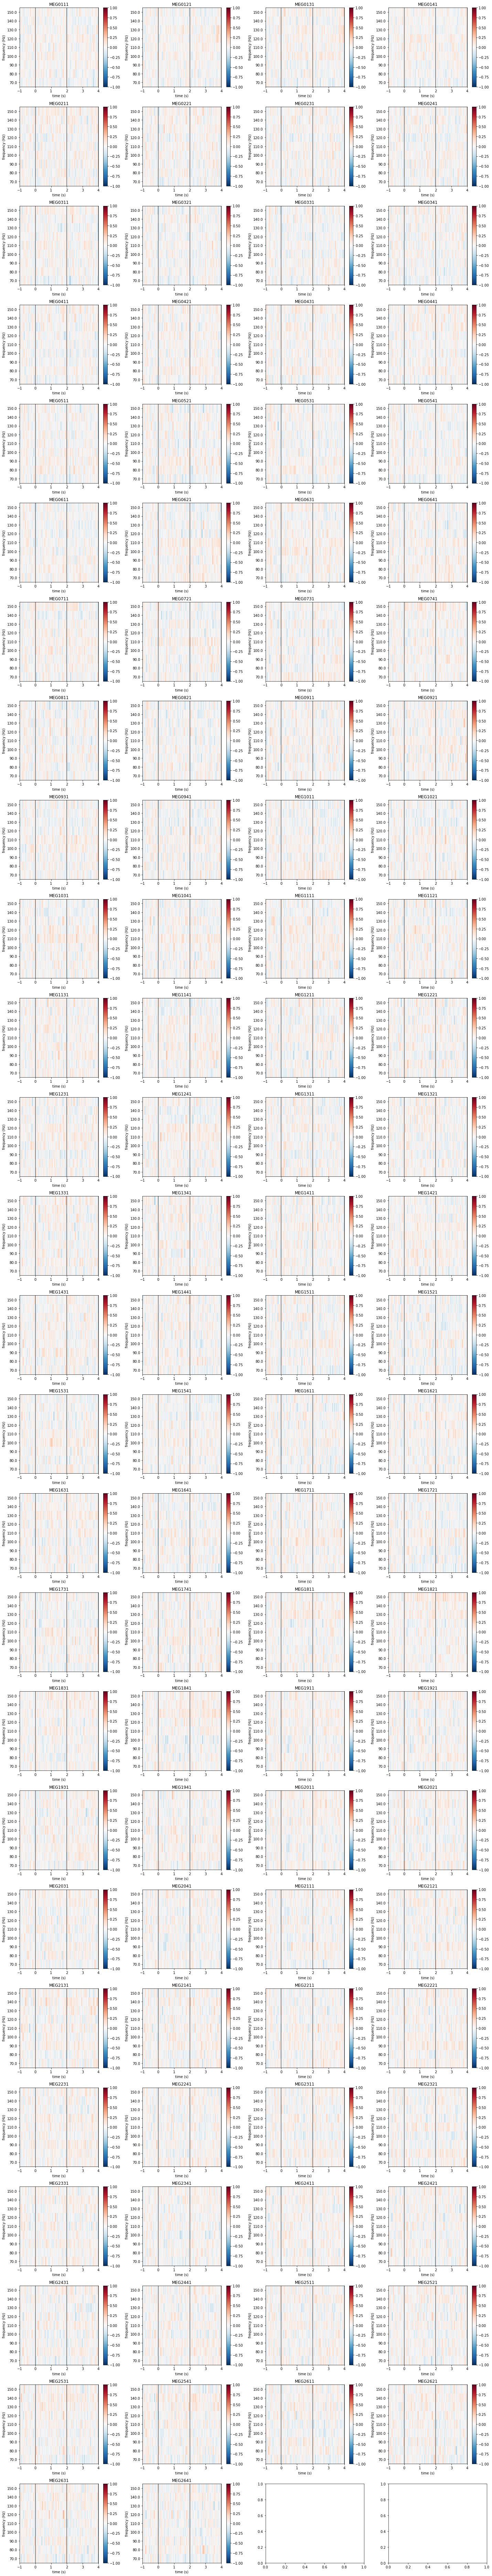

In [73]:
manip_avg = TFRhigh['manip'].average()
maint_avg = TFRhigh['maint'].average()
diff = manip_avg.__sub__(maint_avg)
plot_induced_TFR(TFRhigh.average().apply_baseline([-1,0]))

Applying baseline correction (mode: mean)
No baseline correction applied


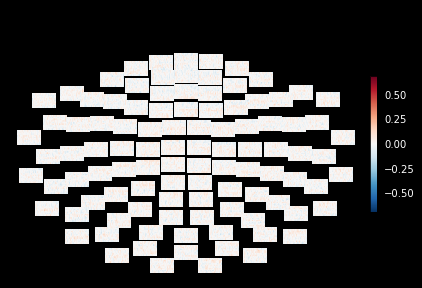

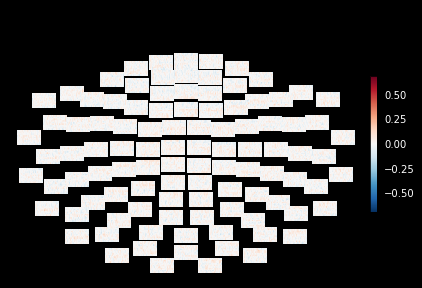

In [75]:
TFRhigh.average().apply_baseline([-1,0]).plot_topo()

In [31]:
# create melody specific codes
# Recode melody 1 and 2
class_labels = [((ll // 10) - 1) % 2 for ll in epochs.events[:,2]]
print('comparing triggers and class labels')
for x,y in zip(class_labels, epochs.events[:,2]):
    print(y,x)

comparing triggers and class labels
13 0
12 0
11 0
11 0
21 1
23 1
23 1
12 0
21 1
12 0
11 0
21 1
12 0
22 1
22 1
21 1
11 0
13 0
13 0
22 1
22 1
13 0
13 0
23 1
21 1
23 1
23 1
21 1
11 0
11 0
23 1
12 0
21 1
23 1
21 1
22 1
12 0
21 1
11 0
21 1
21 1
11 0
22 1
11 0
13 0
22 1
21 1
11 0
11 0
31 0
31 0
31 0
42 1
42 1
42 1
42 1
41 1
41 1
33 0
41 1
43 1
33 0
41 1
41 1
33 0
42 1
41 1
43 1
41 1
31 0
31 0
32 0
32 0
31 0
32 0
43 1
41 1
33 0
41 1
42 1
33 0
32 0
31 0
31 0
32 0
33 0
41 1
41 1
41 1
31 0
41 1
43 1
31 0
41 1
42 1
33 0
41 1
43 1
31 0
31 0
42 1
31 0
32 0
43 1
43 1
33 0


In [4]:
evokeds = dict((cond,epochs[cond].average()) for
                        cond in sorted(epochs.event_id.keys()))

In [5]:
other_conds = ['maint','manip','maint/mel1','maint/mel2','manip/mel1','manip/mel2']
for oc in other_conds:
    evokeds[oc] = epochs[oc].average()
    evokeds[oc].comment = oc

In [6]:
evokeds

{'maint/mel1/diff1': <Evoked | 'maint/mel1/diff1' (average, N=6), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'maint/mel1/diff2': <Evoked | 'maint/mel1/diff2' (average, N=6), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'maint/mel1/same': <Evoked | 'maint/mel1/same' (average, N=11), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'maint/mel2/diff1': <Evoked | 'maint/mel2/diff1' (average, N=7), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'maint/mel2/diff2': <Evoked | 'maint/mel2/diff2' (average, N=7), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'maint/mel2/same': <Evoked | 'maint/mel2/same' (average, N=12), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'manip/mel1/inv': <Evoked | 'manip/mel1/inv' (average, N=13), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'manip/mel1/other1': <Evoked | 'manip/mel1/other1' (average, N=6), -0.1 – 6.5 sec, baseline off, 306 ch, ~6.7 MB>,
 'manip/mel1/other2': <Evoked | 'manip/mel1/other2' (average, N=8), -0.1 – 6.5 sec, baselin

No projector specified for this dataset. Please consider the method self.add_proj.


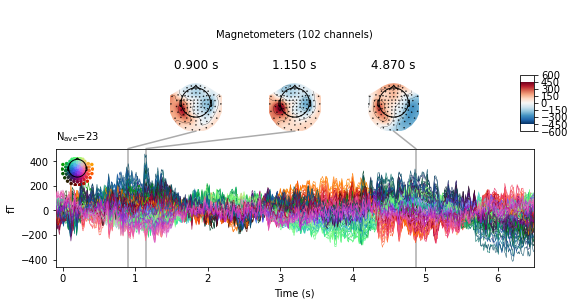

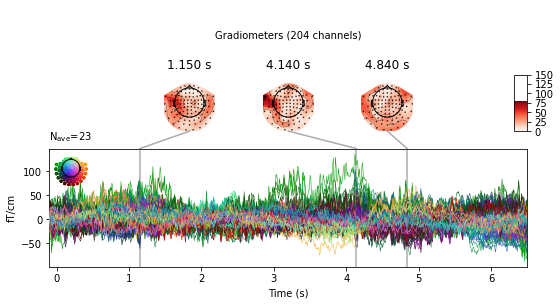

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [13]:
evokeds['maint/mel1'].plot_joint()